# Custom optimsation pipeline

Mean function and kernel share paramters which are inherently seperate in GPJax due to pytree structure. This notebook implements a custom optimisation pipeline to combine the two, enabling parameter sharing.

In [1]:
import numpy as np
import gpjax as gpx
import os
import jax
import matplotlib.pyplot as plt
import jax.random as jr

from dataclasses import dataclass, field

import jax.numpy as jnp
from jaxtyping import Float
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

from gpjax.base import param_field, static_field
from gpjax.kernels.base import AbstractKernel
from gpjax.kernels.stationary.utils import squared_distance
from gpjax.typing import (
    Array,
    ScalarFloat,
)
from jaxtyping import (
    Float,
    Num,
)

import cola
from cola.ops import (
    Dense,
    Diagonal,
    LinearOperator,
)

from gpjax.distributions import GaussianDistribution

from beartype.typing import Callable, Any
from jaxtyping import Int

import sys
import os
abs_path = os.path.abspath('../src')
sys.path.append(abs_path)
from p53_data import JAXP53_Data, dataset_3d, generate_test_times
from kernels import latent_kernel
from custom_gps import p53_posterior
from plotter import plot_gp

jax.config.update('jax_enable_x64', True)

from matplotlib import rcParams

plt.style.use("https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle")

# Check if LaTeX is in notebook path
if os.environ.get('PATH') is not None:
    if 'TeX' not in os.environ['PATH']:
        os.environ['PATH'] += os.pathsep + '/Library/TeX/texbin'

colors = rcParams["axes.prop_cycle"].by_key()["color"]

import tensorflow_probability.substrates.jax.bijectors as tfb

key = jr.PRNGKey(42)

/opt/anaconda3/envs/gpjax_wp289/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from gpjax.base import meta_leaves
from jax.tree_util import register_pytree_node_class

In [3]:
import beartype.typing as tp
Kernel = tp.TypeVar("Kernel", bound="gpjax.kernels.base.AbstractKernel")

In [4]:
p53_data = JAXP53_Data(replicate=0, data_dir='../data')
training_times, gene_expressions, variances = dataset_3d(p53_data)

In [5]:
@dataclass
class latent_kernel(gpx.kernels.AbstractKernel):
    r"Combined covariance for learning the latent replication of p53"

    name: str = "p53 Cov"

    # Define parameters

    # Sensitivities of the genes
    initial_sensitivities = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0], dtype=jnp.float64)

    true_s: Float[Array, "1 5"] = param_field(
        initial_sensitivities,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_sensitivities"},
        trainable=True,
    )

    # Degradation rates of the genes
    initial_decays = jnp.array([0.4, 0.4, 0.4, 0.4, 0.4], dtype=jnp.float64)

    true_d: Float[Array, "1 5"] = param_field(
        initial_decays,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_degradations"},
        trainable=True,
    )

    # Sigmoid to map real numbers to (0,1) and then scales and shifts to get(0.5, 3.5) # NOTE: tfb.Chain acts Right to Left
    l_bijector = tfb.Chain(
        [
            tfb.Shift(jnp.array(0.5, dtype=jnp.float64)),
            tfb.Scale(jnp.array(3.0, dtype=jnp.float64)),
            tfb.Sigmoid(),
        ]
    )

    initial_lengthscale = jnp.array(2.5, dtype=jnp.float64)

    lengthscale: Float[Array, " O"] = param_field(
        initial_lengthscale, bijector=l_bijector, metadata={"name": "lengthscale"}
    )

    # Redefine parameters as static fields
    #true_s: Float[Array, "1 5"] = static_field(jnp.array([1.0,1.0,1.0,1.0,1.0]))
    #true_d: Float[Array, "1 5"] = static_field(jnp.array([0.4,0.4,0.4,0.4,0.4]))
    #l: Float[Array, " O"] = static_field(jnp.array(2.5))

    def __call__(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        # Get flag from input (1 = gene expression, 0 = latent force function)
        f1 = jnp.array(t[2], dtype=int)
        f2 = jnp.array(t_prime[2], dtype=int)

        # Cannot use if statements in kernels -> use switches
        kxx_switch = f1 * f2
        kff_switch = (1 - f1) * (1 - f2)
        kxf_switch = f1 * (1 - f2)
        kxf_t_switch = (1 - f1) * f2

        final_kernel = (
            kxx_switch * self.kernel_xx(t, t_prime)
            + kff_switch * self.kernel_ff(t, t_prime)
            + kxf_switch * self.kernel_xf(t, t_prime)
            + kxf_t_switch * self.kernel_xf(t, t_prime).T
        )

        return final_kernel
    
    def kernel_xx(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        # Get gene indices
        j = t[1].astype(int)
        k = t_prime[1].astype(int)

        t = t[0]
        t_prime = t_prime[0]

        # Equation 5
        mult = self.true_s[j] * self.true_s[k] * self.lengthscale * jnp.sqrt(jnp.pi) * 0.5
        second_term = self.h(k, j, t_prime, t) + self.h(j, k, t, t_prime)

        kxx = mult * second_term
        
        return kxx.squeeze()
    
    def kernel_xf(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        gene_xpr = jnp.where(t[2] == 0, t_prime, t)
        latent_force = jnp.where(t[2] == 0, t, t_prime)

        j = gene_xpr[1].astype(int)

        # Slice inputs
        gene_xpr = gene_xpr[0]
        latent_force = latent_force[0]

        t_dist = gene_xpr - latent_force

        first_term = 0.5 * self.lengthscale * jnp.sqrt(jnp.pi) * self.true_s[j]
        first_expon_term = jnp.exp(self.gamma(j) ** 2)
        second_expon_term = jnp.exp(-self.true_d[j] * t_dist)
        erf_terms = jax.scipy.special.erf(
            (t_dist / self.lengthscale) - self.gamma(j)
        ) + jax.scipy.special.erf(latent_force / self.lengthscale + self.gamma(j))

        kxf = first_term * first_expon_term * second_expon_term * erf_terms
        
        return kxf.squeeze()
    
    def kernel_ff(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
            
        t = t[0].reshape(-1)
        t_prime = t_prime[0].reshape(-1)

        sq_dist = jnp.square(t.reshape(-1, 1) - t_prime)
        sq_dist = jnp.divide(sq_dist, 2 * self.lengthscale.reshape((-1, 1)))

        K = jnp.exp(-sq_dist)

        return K.squeeze() 
    
    # Helper functions
    def h(self, j: Float[Array, " O"], k: Float[Array, " O"], t1: Float[Array, " O"], t2: Float[Array, " O"]) -> ScalarFloat:
        """
        Analytical solution for the convolution of the exponential kernel with a step function.
        """

        # Debug print
        """
        print(f"j: {j}")
        print(f"k: {k}")
        print(f"t1: {t1}")
        print(f"t2: {t2}")
        """
        t_dist = t2 - t1

        multiplier = jnp.exp(self.gamma(k) ** 2) / (self.true_d[j] + self.true_d[k])

        first_multiplier = jnp.exp(-self.true_d[k] * t_dist)
        
        first_erf_terms = jax.scipy.special.erf(
            (t_dist / self.lengthscale) - self.gamma(k)
        ) + jax.scipy.special.erf(t1 / self.lengthscale + self.gamma(k))

        second_multiplier = jnp.exp(-(self.true_d[k] * t2 + self.true_d[j] * t1))
        
        second_erf_terms = jax.scipy.special.erf(
            (t2 / self.lengthscale) - self.gamma(k)
        ) + jax.scipy.special.erf(self.gamma(k))

        result = multiplier * (
            jnp.multiply(first_multiplier, first_erf_terms)
            - jnp.multiply(second_multiplier, second_erf_terms)
        )

        #print(f"result: {result}")
        return result

    def gamma(self, k: Float[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.true_d[k] * self.lengthscale) / 2

In [6]:
def optimise_mll(posterior, dataset, NIters=1000, key=key):
    # define the MLL using dataset_train
    objective = gpx.objectives.ConjugateMLL(negative=True)
    print(f'MLL before opt: {objective(posterior, dataset):.3f}')
    # Optimise to minimise the MLL
    opt_posterior, history = gpx.fit_scipy(
        model=posterior,
        objective=objective,
        train_data=dataset,
    )
    return opt_posterior, history

In [7]:
# Function definitions
def initialise_gp(kernel, mean, dataset):
    prior = gpx.gps.Prior(mean_function=mean, kernel=kernel, jitter=1e-4)
    likelihood = gpx.likelihoods.Gaussian(
        num_datapoints=dataset.n, obs_stddev=jnp.array([1.0e-3], dtype=jnp.float64)
    )
    posterior = prior * likelihood
    return posterior

In [8]:
p53_data = JAXP53_Data(replicate=0, data_dir='../data')
training_times, gene_expressions, variances = dataset_3d(p53_data)

dataset_train = gpx.Dataset(training_times, gene_expressions)

testing_times = generate_test_times()

meanf = gpx.mean_functions.Zero()
p53_ker = latent_kernel()

In [9]:
# Obtain posterior distribution
posterior = initialise_gp(p53_ker, meanf, dataset_train)

# Optimisise MLL for GPR to obtain optimised posterior
opt_post, history = optimise_mll(posterior, dataset_train)

# Predict latent function using custom posterior and prediction method
p53_post = p53_posterior(prior=opt_post.prior, likelihood=opt_post.likelihood)
latent_dist = p53_post.latent_predict(testing_times, p53_data)

predictive_dist = p53_post.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

# Plot the GP
f = p53_data.f_observed.squeeze()

MLL before opt: 34739.847
Optimization terminated successfully.
         Current function value: 8.756255
         Iterations: 173
         Function evaluations: 206
         Gradient evaluations: 206


In [10]:
prior = posterior.prior
jax.tree_util.tree_leaves(prior)

[Array(2.5, dtype=float64),
 Array([0.4, 0.4, 0.4, 0.4, 0.4], dtype=float64),
 Array([1., 1., 1., 1., 1.], dtype=float64)]

In [11]:
len(meta_leaves(opt_post))

4

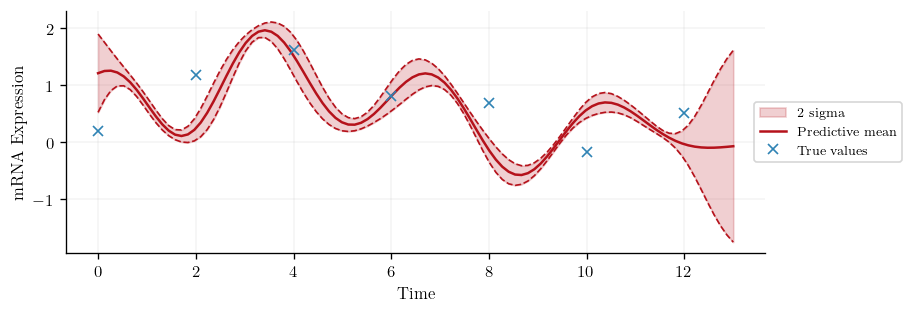

In [12]:
plot_gp(testing_times, latent_dist, y_scatter=f)

In [ ]:
# Custom mean function
# Define custom mean
@dataclass
class latent_mean(gpx.mean_functions.AbstractMeanFunction):
    r"""
    Simple Input Motif mean function

    ```math
        f(x_{j}) = \frac{B_{j}}{D_{j}} 
    ```

    From equation 2 in paper.

    $B_{j}$ represents the basal rate for gene $j$ and is a trainable paramater.
    """

    # Pass kernel instance that contains true_d parameter
    kernel: gpx.kernels.AbstractKernel = field(default_factory=lambda: latent_kernel())
    
    #true_d: Float[Array, "1 5"] = static_field(jnp.array([0.05, 0.05, 0.05, 0.05, 0.05], dtype=jnp.float64))
    
    # Define parameters
    initial_constrained_b = jnp.array([0.05, 0.05, 0.05, 0.05, 0.05], dtype=jnp.float64)
    
    true_b: Float[Array, "1 5"] = param_field(initial_constrained_b, bijector=tfb.Softplus(), metadata={"name": " basal_rates"}, trainable=True,)

    def __call__(self, x: Float[Array, "N D"]) -> Float[Array, "N O"]:
        r"""Evaluate the mean function at the given points.

        Args:
            x (Float[Array, " D"]): The point at which to evaluate the mean function.

        Returns
        -------
            Float[Array, "1"]: The evaluated mean function.
        """
        # BUG: Concretization error if this is used ?
        #num_genes = len(jnp.unique(x[:, 1]))
        num_genes = 5

        decays = self.kernel.true_d
        
        block_size = (x.shape[0] // num_genes)
        # Define the mean function
        #mean = (self.true_b / self.true_d).reshape(1, -1)
        mean = (self.true_b / decays).reshape(1, -1)
        mean = mean.repeat(block_size, jnp.newaxis).reshape(-1,1)

        return mean

## Custom model

The optimisation method `fit_scipy` takes in a custom model (by default this is the posterior which seperates the mean and kernel functions). Next, a custom model allowing for the sharing of parameters will be defined.

In [20]:
# define model

class p53_model(gpx.base.Module):
    """
    Implementation of p53 model from Lawrence et al. 2006
    """
    ####### Define parameters

    # Sensitivities of the genes
    initial_sensitivities = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0], dtype=jnp.float64)

    true_s: Float[Array, "1 5"] = param_field(
        initial_sensitivities,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_sensitivities"},
        trainable=True,
    )

    # Degradation rates of the genes
    initial_decays = jnp.array([0.4, 0.4, 0.4, 0.4, 0.4], dtype=jnp.float64)

    true_d: Float[Array, "1 5"] = param_field(
        initial_decays,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_degradations"},
        trainable=True,
    )

    # Sigmoid to map real numbers to (0,1) and then scales and shifts to get(0.5, 3.5) # NOTE: tfb.Chain acts Right to Left
    l_bijector = tfb.Chain(
        [
            tfb.Shift(jnp.array(0.5, dtype=jnp.float64)),
            tfb.Scale(jnp.array(3.0, dtype=jnp.float64)),
            tfb.Sigmoid(),
        ]
    )

    initial_lengthscale = jnp.array(2.5, dtype=jnp.float64)

    lengthscale: Float[Array, " O"] = param_field(
        initial_lengthscale, bijector=l_bijector, metadata={"name": "lengthscale"}
    )
    
    initial_constrained_b = jnp.array([0.05, 0.05, 0.05, 0.05, 0.05], dtype=jnp.float64)
    
    true_b: Float[Array, "1 5"] = param_field(initial_constrained_b, bijector=tfb.Softplus(), metadata={"name": " basal_rates"}, trainable=True)

    
    # Define mean function (TODO: change zero mean)
    def mean(self, x: Num[Array, "N D"]) -> Float[Array, "N O"]:
        return jnp.ones((x.shape[0], 1)) * 0
    
    # Define kernel
    def kernel(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        # Get flag from input (1 = gene expression, 0 = latent force function)
        f1 = jnp.array(t[2], dtype=int)
        f2 = jnp.array(t_prime[2], dtype=int)

        # Cannot use if statements in kernels -> use switches
        kxx_switch = f1 * f2
        kff_switch = (1 - f1) * (1 - f2)
        kxf_switch = f1 * (1 - f2)
        kxf_t_switch = (1 - f1) * f2

        final_kernel = (
            kxx_switch * self.kernel_xx(t, t_prime)
            + kff_switch * self.kernel_ff(t, t_prime)
            + kxf_switch * self.kernel_xf(t, t_prime)
            + kxf_t_switch * self.kernel_xf(t, t_prime).T
        )

        return final_kernel
    
    def kernel_xx(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        # Get gene indices
        j = t[1].astype(int)
        k = t_prime[1].astype(int)

        t = t[0]
        t_prime = t_prime[0]

        # Equation 5
        mult = self.true_s[j] * self.true_s[k] * self.l * jnp.sqrt(jnp.pi) * 0.5
        second_term = self.h(k, j, t_prime, t) + self.h(j, k, t, t_prime)

        kxx = mult * second_term
        
        return kxx.squeeze()
    
    def kernel_xf(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        gene_xpr = jnp.where(t[2] == 0, t_prime, t)
        latent_force = jnp.where(t[2] == 0, t, t_prime)

        j = gene_xpr[1].astype(int)

        # Slice inputs
        gene_xpr = gene_xpr[0]
        latent_force = latent_force[0]

        t_dist = gene_xpr - latent_force

        first_term = 0.5 * self.l * jnp.sqrt(jnp.pi) * self.true_s[j]
        first_expon_term = jnp.exp(self.gamma(j) ** 2)
        second_expon_term = jnp.exp(-self.true_d[j] * t_dist)
        erf_terms = jax.scipy.special.erf(
            (t_dist / self.l) - self.gamma(j)
        ) + jax.scipy.special.erf(latent_force / self.l + self.gamma(j))

        kxf = first_term * first_expon_term * second_expon_term * erf_terms
        
        return kxf.squeeze()
    
    def kernel_ff(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
            
        t = t[0].reshape(-1)
        t_prime = t_prime[0].reshape(-1)

        sq_dist = jnp.square(t.reshape(-1, 1) - t_prime)
        sq_dist = jnp.divide(sq_dist, 2 * self.l.reshape((-1, 1)))

        K = jnp.exp(-sq_dist)

        return K.squeeze() 
    
    # Helper functions
    def h(self, j: Float[Array, " O"], k: Float[Array, " O"], t1: Float[Array, " O"], t2: Float[Array, " O"]) -> ScalarFloat:

        t_dist = t2 - t1

        multiplier = jnp.exp(self.gamma(k) ** 2) / (self.true_d[j] + self.true_d[k])

        first_multiplier = jnp.exp(-self.true_d[k] * t_dist)
        
        first_erf_terms = jax.scipy.special.erf(
            (t_dist / self.l) - self.gamma(k)
        ) + jax.scipy.special.erf(t1 / self.l + self.gamma(k))

        second_multiplier = jnp.exp(-(self.true_d[k] * t2 + self.true_d[j] * t1))
        
        second_erf_terms = jax.scipy.special.erf(
            (t2 / self.l) - self.gamma(k)
        ) + jax.scipy.special.erf(self.gamma(k))

        result = multiplier * (
            jnp.multiply(first_multiplier, first_erf_terms)
            - jnp.multiply(second_multiplier, second_erf_terms)
        )

        #print(f"result: {result}")
        return result

    def gamma(self, k: Float[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.true_d[k] * self.l) / 2
    
    
    # Calculate cross-covariance
    def cross_covariance(
        self, kernel: Kernel, x: Float[Array, "N D"], y: Float[Array, "M D"]
    ) -> Float[Array, "N M"]:
        cross_cov = jax.vmap(lambda x: jax.vmap(lambda y: kernel(x, y))(y))(x)
        return cross_cov

    def gram(self, kernel: Kernel, x: Float[Array, "N D"]) -> LinearOperator:
        Kxx = self.cross_covariance(kernel, x, x)
        return cola.PSD(Dense(Kxx))


    ############################
    # Define predict method
    def latent_predict(
        self, test_inputs: Num[Array, "N D"], train_data: JAXP53_Data
    ) -> GaussianDistribution:
    
        x, y, variances = dataset_3d(train_data)
        t = test_inputs
        jitter = 1e-4

        diag_variances = jnp.diag(variances.reshape(-1))
        Kxx = self.gram(self.kernel, x)
        Kxx += diag_variances
        Kxx += cola.ops.I_like(Kxx) * jitter
        K_inv = cola.inv(Kxx)

        Kxf = self.cross_covariance(self.kernel, x, t)
        KfxKxx = jnp.matmul(Kxf.T, K_inv.to_dense())
        mean = jnp.matmul(KfxKxx, y)

        Kff = self.gram(self.kernel, t)
        Kff += cola.ops.I_like(Kff) * jitter * 10

        var = Kff - jnp.matmul(KfxKxx, Kxf)
        var = jnp.diag(jnp.diag(var.to_dense()))
        var += cola.ops.I_like(var) * jitter * 10

        return GaussianDistribution(jnp.atleast_1d(mean.squeeze()), var)

In [26]:
objective = gpx.objectives.ConjugateMLL(negative=True)

model = p53_model()

opt_model, history = gpx.fit_scipy(
    model=model,
    objective=objective,
    train_data=dataset_train,
)

AttributeError: 'p53_model' object has no attribute 'likelihood'

AttributeError: 'p53_model' object has no attribute 'likelihood'

In [ ]:
class ConjugateMLL(AbstractObjective):
    def step(
        self,
        posterior: ConjugatePosterior,
        train_data: Dataset,
    ) -> ScalarFloat:

        x, y = train_data.X, train_data.y

        # Observation noise o²
        obs_noise = posterior.likelihood.obs_stddev**2
        mx = posterior.prior.mean_function(x)

        # Σ = (Kxx + Io²) = LLᵀ
        Kxx = posterior.prior.kernel.gram(x)
        Kxx += cola.ops.I_like(Kxx) * posterior.prior.jitter
        Sigma = Kxx + cola.ops.I_like(Kxx) * obs_noise
        Sigma = cola.PSD(Sigma)

        # p(y | x, θ), where θ are the model hyperparameters:
        mll = GaussianDistribution(jnp.atleast_1d(mx.squeeze()), Sigma)

        return self.constant * (mll.log_prob(jnp.atleast_1d(y.squeeze())).squeeze())

In [28]:
def construct_posterior(prior, likelihood):
    r"""Utility function for constructing a posterior object from a prior and
    likelihood. The function will automatically select the correct posterior
    object based on the likelihood.

    Args:
        prior (Prior): The Prior distribution.
        likelihood (AbstractLikelihood): The likelihood that represents our
            beliefs around the distribution of the data.

    Returns
    -------
        AbstractPosterior: A posterior distribution. If the likelihood is
            Gaussian, then a `ConjugatePosterior` will be returned. Otherwise,
            a `NonConjugatePosterior` will be returned.
    """
    return gpx.gps.ConjugatePosterior(prior=prior, likelihood=likelihood)


In [ ]:
class custom_prior(gpx.base.Module):
    # Custom prior which combines mean and kernel

    # Prior set-up
    def __call__(self, *args: Any, **kwargs: Any) -> GaussianDistribution:
        r"""Evaluate the Gaussian process at the given points"""
        return self.predict(*args, **kwargs)
    

    def __mul__(self, other):
        r"""Combine the prior with a likelihood to form a posterior distribution.""" 
        
        return construct_posterior(self, other)
    
    def __rmul__(self, other):
        r"""Combine the prior with a likelihood to form a posterior distribution.

        Reimplement the multiplication operator to allow for order-invariant
        product of a likelihood and a prior i.e., likelihood * prior.
        """
        return self.__mul__(other)
    
    # Calculate cross-covariance (for kernel evaluations)
    def cross_covariance(
        self, kernel: Kernel, x: Float[Array, "N D"], y: Float[Array, "M D"]
    ) -> Float[Array, "N M"]:
        cross_cov = jax.vmap(lambda x: jax.vmap(lambda y: kernel(x, y))(y))(x)
        return cross_cov
    
    # Calculate gram matrix
    def gram(self, kernel: Kernel, x: Float[Array, "N D"]) -> LinearOperator:
        Kxx = self.cross_covariance(kernel, x, x)
        return cola.PSD(Dense(Kxx))
    

    def mean_function():
        raise NotImplementedError
    
    def kernel():
        raise NotImplementedError

    


In [35]:
# combined mean and kernel

@dataclass
class mean_cov(gpx.base.Module):
    ####### Define parameters

    # Sensitivities of the genes
    initial_sensitivities = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0], dtype=jnp.float64)

    true_s: Float[Array, "1 5"] = param_field(
        initial_sensitivities,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_sensitivities"},
        trainable=True,
    )

    # Degradation rates of the genes
    initial_decays = jnp.array([0.4, 0.4, 0.4, 0.4, 0.4], dtype=jnp.float64)

    true_d: Float[Array, "1 5"] = param_field(
        initial_decays,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_degradations"},
        trainable=True,
    )

    # Sigmoid to map real numbers to (0,1) and then scales and shifts to get(0.5, 3.5) # NOTE: tfb.Chain acts Right to Left
    l_bijector = tfb.Chain(
        [
            tfb.Shift(jnp.array(0.5, dtype=jnp.float64)),
            tfb.Scale(jnp.array(3.0, dtype=jnp.float64)),
            tfb.Sigmoid(),
        ]
    )

    initial_lengthscale = jnp.array(2.5, dtype=jnp.float64)

    lengthscale: Float[Array, " O"] = param_field(
        initial_lengthscale, bijector=l_bijector, metadata={"name": "lengthscale"}
    )
    
    initial_constrained_b = jnp.array([0.05, 0.05, 0.05, 0.05, 0.05], dtype=jnp.float64)
    
    true_b: Float[Array, "1 5"] = param_field(initial_constrained_b, bijector=tfb.Softplus(), metadata={"name": " basal_rates"}, trainable=True)

    
    # Define mean function (TODO: change zero mean)
    def mean(self, x: Num[Array, "N D"]) -> Float[Array, "N O"]:
        return jnp.ones((x.shape[0], 1)) * 0
    
    # Define kernel
    def kernel(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        # Get flag from input (1 = gene expression, 0 = latent force function)
        f1 = jnp.array(t[2], dtype=int)
        f2 = jnp.array(t_prime[2], dtype=int)

        # Cannot use if statements in kernels -> use switches
        kxx_switch = f1 * f2
        kff_switch = (1 - f1) * (1 - f2)
        kxf_switch = f1 * (1 - f2)
        kxf_t_switch = (1 - f1) * f2

        final_kernel = (
            kxx_switch * self.kernel_xx(t, t_prime)
            + kff_switch * self.kernel_ff(t, t_prime)
            + kxf_switch * self.kernel_xf(t, t_prime)
            + kxf_t_switch * self.kernel_xf(t, t_prime).T
        )

        return final_kernel
     
    def kernel_xx(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        # Get gene indices
        j = t[1].astype(int)
        k = t_prime[1].astype(int)

        t = t[0]
        t_prime = t_prime[0]

        # Equation 5
        mult = self.true_s[j] * self.true_s[k] * self.lengthscale * jnp.sqrt(jnp.pi) * 0.5
        second_term = self.h(k, j, t_prime, t) + self.h(j, k, t, t_prime)

        kxx = mult * second_term
        
        return kxx.squeeze()
    
    def kernel_xf(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        gene_xpr = jnp.where(t[2] == 0, t_prime, t)
        latent_force = jnp.where(t[2] == 0, t, t_prime)

        j = gene_xpr[1].astype(int)

        # Slice inputs
        gene_xpr = gene_xpr[0]
        latent_force = latent_force[0]

        t_dist = gene_xpr - latent_force

        first_term = 0.5 * self.lengthscale * jnp.sqrt(jnp.pi) * self.true_s[j]
        first_expon_term = jnp.exp(self.gamma(j) ** 2)
        second_expon_term = jnp.exp(-self.true_d[j] * t_dist)
        erf_terms = jax.scipy.special.erf(
            (t_dist / self.lengthscale) - self.gamma(j)
        ) + jax.scipy.special.erf(latent_force / self.lengthscale + self.gamma(j))

        kxf = first_term * first_expon_term * second_expon_term * erf_terms
        
        return kxf.squeeze()
    
    def kernel_ff(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
            
        t = t[0].reshape(-1)
        t_prime = t_prime[0].reshape(-1)

        sq_dist = jnp.square(t.reshape(-1, 1) - t_prime)
        sq_dist = jnp.divide(sq_dist, 2 * self.lengthscale.reshape((-1, 1)))

        K = jnp.exp(-sq_dist)

        return K.squeeze() 
    
    # Helper functions
    def h(self, j: Float[Array, " O"], k: Float[Array, " O"], t1: Float[Array, " O"], t2: Float[Array, " O"]) -> ScalarFloat:

        t_dist = t2 - t1

        multiplier = jnp.exp(self.gamma(k) ** 2) / (self.true_d[j] + self.true_d[k])

        first_multiplier = jnp.exp(-self.true_d[k] * t_dist)
        
        first_erf_terms = jax.scipy.special.erf(
            (t_dist / self.lengthscale) - self.gamma(k)
        ) + jax.scipy.special.erf(t1 / self.lengthscale + self.gamma(k))

        second_multiplier = jnp.exp(-(self.true_d[k] * t2 + self.true_d[j] * t1))
        
        second_erf_terms = jax.scipy.special.erf(
            (t2 / self.lengthscale) - self.gamma(k)
        ) + jax.scipy.special.erf(self.gamma(k))

        result = multiplier * (
            jnp.multiply(first_multiplier, first_erf_terms)
            - jnp.multiply(second_multiplier, second_erf_terms)
        )

        #print(f"result: {result}")
        return result

    def gamma(self, k: Float[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.true_d[k] * self.lengthscale) / 2
    


# Shared params

In [13]:
class model_params(gpx.base.Module):
    # Sensitivities of the genes
    initial_sensitivities = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0], dtype=jnp.float64)

    true_s: Float[Array, "1 5"] = param_field(
        initial_sensitivities,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_sensitivities"},
        trainable=True,
    )

    # Degradation rates of the genes
    initial_decays = jnp.array([0.4, 0.4, 0.4, 0.4, 0.4], dtype=jnp.float64)

    true_d: Float[Array, "1 5"] = param_field(
        initial_decays,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_degradations"},
        trainable=True,
    )

    # Sigmoid to map real numbers to (0,1) and then scales and shifts to get(0.5, 3.5) # NOTE: tfb.Chain acts Right to Left
    l_bijector = tfb.Chain(
        [
            tfb.Shift(jnp.array(0.5, dtype=jnp.float64)),
            tfb.Scale(jnp.array(3.0, dtype=jnp.float64)),
            tfb.Sigmoid(),
        ]
    )

    initial_lengthscale = jnp.array(2.5, dtype=jnp.float64)

    lengthscale: Float[Array, " O"] = param_field(
        initial_lengthscale, bijector=l_bijector, metadata={"name": "lengthscale"}
    )
    
    initial_constrained_b = jnp.array([0.05, 0.05, 0.05, 0.05, 0.05], dtype=jnp.float64)
    
    true_b: Float[Array, "1 5"] = param_field(initial_constrained_b, bijector=tfb.Softplus(), metadata={"name": " basal_rates"}, trainable=True)

In [14]:
@dataclass
class shared_mean(gpx.mean_functions.AbstractMeanFunction):
    #shared_params: model_params
    shared_params: model_params = field(default_factory=model_params)

    def __call__(self, x: Float[Array, "N D"]) -> Float[Array, "N O"]:
        # TODO: replace 0 mean implementation
        
        return jnp.ones((x.shape[0], 1)) * 0


In [24]:
from gpjax.kernels.computations import (
    AbstractKernelComputation,
    DenseKernelComputation,
)

@dataclass
class shared_kernel(gpx.kernels.AbstractKernel, model_params):
    
    #shared_params: model_params = static_field(None)
    shared_params: model_params = field(default_factory=model_params)
    compute_engine: AbstractKernelComputation = static_field(DenseKernelComputation())


    def __call__(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:

        # Get flag from input (1 = gene expression, 0 = latent force function)
        f1 = jnp.array(t[2], dtype=int)
        f2 = jnp.array(t_prime[2], dtype=int)

        # Cannot use if statements in kernels -> use switches
        kxx_switch = f1 * f2
        kff_switch = (1 - f1) * (1 - f2)
        kxf_switch = f1 * (1 - f2)
        kxf_t_switch = (1 - f1) * f2

        final_kernel = (
            kxx_switch * self.kernel_xx(t, t_prime)
            + kff_switch * self.kernel_ff(t, t_prime)
            + kxf_switch * self.kernel_xf(t, t_prime)
            + kxf_t_switch * self.kernel_xf(t, t_prime).T
        )

        return final_kernel
    
    # Required to correctly register with JAX PyTree
    def tree_flatten(self):
        children = (self.shared_params.true_s, self.shared_params.true_d, self.shared_params.lengthscale, self.shared_params.true_b)
        aux_data = {}
        return (children, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        true_s, true_d, lengthscale, true_b = children
        shared_params = model_params(true_s=true_s, true_d=true_d, lengthscale=lengthscale, true_b=true_b)
        return cls(shared_params)
    
    def kernel_xx(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        # Get gene indices
        j = t[1].astype(int)
        k = t_prime[1].astype(int)

        t = t[0]
        t_prime = t_prime[0]

        # Equation 5
        mult = self.shared_params.true_s[j] * self.shared_params.true_s[k] * self.shared_params.lengthscale * jnp.sqrt(jnp.pi) * 0.5
        second_term = self.h(k, j, t_prime, t) + self.h(j, k, t, t_prime)

        kxx = mult * second_term
        
        return kxx.squeeze()
    
    def kernel_xf(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        gene_xpr = jnp.where(t[2] == 0, t_prime, t)
        latent_force = jnp.where(t[2] == 0, t, t_prime)

        j = gene_xpr[1].astype(int)

        # Slice inputs
        gene_xpr = gene_xpr[0]
        latent_force = latent_force[0]

        t_dist = gene_xpr - latent_force

        first_term = 0.5 * self.shared_params.lengthscale * jnp.sqrt(jnp.pi) * self.shared_params.true_s[j]
        first_expon_term = jnp.exp(self.gamma(j) ** 2)
        second_expon_term = jnp.exp(-self.shared_params.true_d[j] * t_dist)
        erf_terms = jax.scipy.special.erf(
            (t_dist / self.shared_params.lengthscale) - self.gamma(j)
        ) + jax.scipy.special.erf(latent_force / self.shared_params.lengthscale + self.gamma(j))

        kxf = first_term * first_expon_term * second_expon_term * erf_terms
        
        return kxf.squeeze()
    
    def kernel_ff(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
            
        t = t[0].reshape(-1)
        t_prime = t_prime[0].reshape(-1)

        sq_dist = jnp.square(t.reshape(-1, 1) - t_prime)
        sq_dist = jnp.divide(sq_dist, 2 * self.shared_params.lengthscale.reshape((-1, 1)))

        K = jnp.exp(-sq_dist)

        return K.squeeze() 
    
    # Helper functions
    def h(self, j: Float[Array, " O"], k: Float[Array, " O"], t1: Float[Array, " O"], t2: Float[Array, " O"]) -> ScalarFloat:

        t_dist = t2 - t1

        multiplier = jnp.exp(self.gamma(k) ** 2) / (self.shared_params.true_d[j] + self.shared_params.true_d[k])

        first_multiplier = jnp.exp(-self.shared_params.true_d[k] * t_dist)
        
        first_erf_terms = jax.scipy.special.erf(
            (t_dist / self.shared_params.lengthscale) - self.gamma(k)
        ) + jax.scipy.special.erf(t1 / self.shared_params.lengthscale + self.gamma(k))

        second_multiplier = jnp.exp(-(self.shared_params.true_d[k] * t2 + self.shared_params.true_d[j] * t1))
        
        second_erf_terms = jax.scipy.special.erf(
            (t2 / self.shared_params.lengthscale) - self.gamma(k)
        ) + jax.scipy.special.erf(self.gamma(k))

        result = multiplier * (
            jnp.multiply(first_multiplier, first_erf_terms)
            - jnp.multiply(second_multiplier, second_erf_terms)
        )

        #print(f"result: {result}")
        return result

    def gamma(self, k: Float[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.shared_params.true_d[k] * self.shared_params.lengthscale) / 2
    



In [25]:
shared_params = model_params()
mean_shared = shared_mean(shared_params)
kernel_shared = shared_kernel(shared_params)

In [26]:
prior_shared = gpx.gps.Prior(mean_function=mean_shared, kernel=kernel_shared, jitter=1e-4)
likelihood_shared = gpx.likelihoods.Gaussian(num_datapoints=dataset_train.n, obs_stddev=jnp.array([1.0e-3], dtype=jnp.float64))

posterior_shared = prior_shared * likelihood_shared

In [27]:
len(jax.tree_util.tree_leaves(prior_shared))

0

In [28]:
posterior_shared.prior.kernel

shared_kernel(compute_engine=<__main__.model_params object at 0x338b9b610>, active_dims=None, name='AbstractKernel', shared_params=<__main__.model_params object at 0x17ec1f550>)

In [29]:
objective = gpx.objectives.ConjugateMLL(negative=True)
print(f'MLL before opt: {objective(posterior_shared, dataset_train):.3f}')

AttributeError: 'model_params' object has no attribute 'gram'

In [138]:
len(jax.tree_util.tree_leaves(posterior_shared))   

16

In [135]:
len(meta_leaves(posterior_shared))

16

In [109]:
opt_posterior_shared, history_shared = optimise_mll(posterior_shared, dataset_train)

MLL before opt: 34739.847
Optimization terminated successfully.
         Current function value: 8.756255
         Iterations: 174
         Function evaluations: 206
         Gradient evaluations: 206


In [117]:
from gpjax.base import meta_leaves

# Get the meta leaves
meta_leaves(opt_posterior_shared)[:4]

[({'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': True,
   'pytree_node': True},
  Array([0.16907871], dtype=float64)),
 ({'name': 'lengthscale',
   'bijector': <tfp.bijectors.Chain 'chain_of_shift_of_scale_of_sigmoid' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float64 dtype_y=float64 bijectors=[<tfp.bijectors.Shift 'shift' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float64 dtype_y=float64>, <tfp.bijectors.Scale 'scale' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float64 dtype_y=float64>, <tfp.bijectors.Sigmoid 'sigmoid' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]>,
   'trainable': True,
   'pytree_node': True},
  Array(2.5, dtype=float64)),
 ({'name': 'lengthscale',
   'bijector': <tfp.bijectors.Chain 'chain_of_shift_of_scale_of_sigmoid' batch_

In [110]:
p53_post_shared = p53_posterior(prior=opt_posterior_shared.prior, likelihood=opt_posterior_shared.likelihood)

latent_dist_shared = p53_post_shared.latent_predict(testing_times, p53_data)
predictive_dist_shared = p53_post_shared.likelihood(latent_dist_shared)

predictive_mean_shared = predictive_dist_shared.mean()
predictive_std_shared = predictive_dist_shared.stddev()


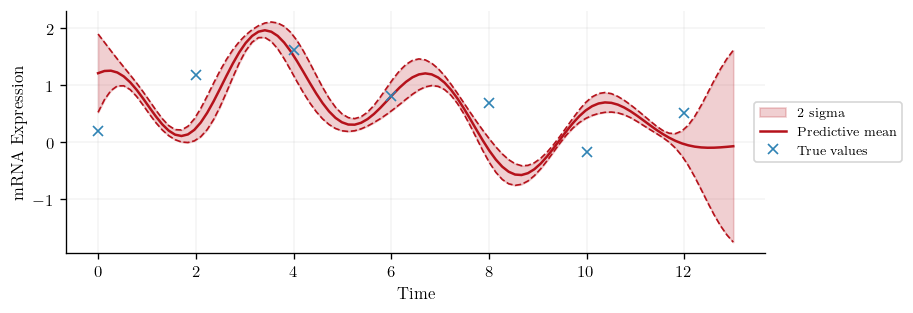

In [111]:
plot_gp(testing_times, latent_dist_shared, y_scatter=f)